In [163]:
import numpy as np
data = np.load('y_test.npy')
print(data)

data = np.load('y_train.npy')
print(data)

data = np.load('X_test_csp.npy')
print(data)

data = np.load('X_train_csp.npy')
print(data)

[1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 1 1]
[0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0
 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0
 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0
 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1
 1 1]
[[ 0.90214351 -1.75014763 -0.89634681 -1.25476078]
 [-2.26659025 -0.03098215 -1.75247033 -0.20734934]
 [ 1.05266148 -0.71585324  1.64912601 -0.61805508]
 [-2.4218689  -1.18562095 -1.6798437  -1.05669646]
 [-2.27933439 -1.00769446 -1.75670378 -1.31082521]
 [-2.35498769 -1.68090246 -1.35714137 -1.75328858]
 [ 0.07253534 -1.87709109 -0.02741978 -1.72196256]
 [-2.14237909 -0.13654898 -1.75428729 -0.27314113]
 [-2.50576409 -1.89691657 -2.15525595 -2.10866524]
 [ 4.35517827  1.10500705  4.48425294  0.13744678]
 [-1.89357864 -0.68734724 -0.63243492 -0.18776827]
 [-2.53977422 -1.17150051 -1.9

In [164]:
# ===============================
# Load CSP features and labels
# ===============================

X_train = np.load("X_train_csp.npy")
X_test  = np.load("X_test_csp.npy")

y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

Train shape: (150, 4) (150,)
Test shape : (50, 4) (50,)


In [165]:
# Convert labels from {0,1} to {-1,+1}
y_train = np.where(y_train == 0, -1, 1)
y_test  = np.where(y_test  == 0, -1, 1)

In [166]:
# ===============================
# Standardization
# ===============================

mean = X_train.mean(axis=0)
std  = X_train.std(axis=0) + 1e-8  # جلوگیری از تقسیم بر صفر

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

In [167]:
# ===============================
# RBF Kernel
# ===============================

def rbf_kernel(x1, x2, gamma):
    diff = x1 - x2
    return np.exp(-gamma * np.dot(diff, diff))

In [168]:
class KernelSVM:
    def __init__(self, C=10.0, gamma=0.01, tol=1e-3, max_passes=5):
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_passes = max_passes

    def fit(self, X, y):
        self.X = X
        self.y = y
        N = X.shape[0]

        self.alphas = np.zeros(N)
        self.b = 0.0

        K = self._compute_kernel_matrix(X)

        passes = 0
        while passes < self.max_passes:
            num_changed = 0

            for i in range(N):
                Ei = self._decision_function_row(K, i) - y[i]

                if (y[i]*Ei < -self.tol and self.alphas[i] < self.C) or \
                   (y[i]*Ei >  self.tol and self.alphas[i] > 0):

                    j = np.random.choice([x for x in range(N) if x != i])
                    Ej = self._decision_function_row(K, j) - y[j]

                    ai_old, aj_old = self.alphas[i], self.alphas[j]

                    # Compute bounds L and H
                    if y[i] != y[j]:
                        L = max(0, aj_old - ai_old)
                        H = min(self.C, self.C + aj_old - ai_old)
                    else:
                        L = max(0, ai_old + aj_old - self.C)
                        H = min(self.C, ai_old + aj_old)

                    if L == H:
                        continue

                    eta = 2*K[i,j] - K[i,i] - K[j,j]
                    if eta >= 0:
                        continue

                    self.alphas[j] -= y[j] * (Ei - Ej) / eta
                    self.alphas[j] = np.clip(self.alphas[j], L, H)

                    if abs(self.alphas[j] - aj_old) < 1e-5:
                        continue

                    self.alphas[i] += y[i]*y[j]*(aj_old - self.alphas[j])

                    # Update bias
                    b1 = self.b - Ei \
                         - y[i]*(self.alphas[i]-ai_old)*K[i,i] \
                         - y[j]*(self.alphas[j]-aj_old)*K[i,j]

                    b2 = self.b - Ej \
                         - y[i]*(self.alphas[i]-ai_old)*K[i,j] \
                         - y[j]*(self.alphas[j]-aj_old)*K[j,j]

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed += 1

            if num_changed == 0:
                passes += 1
            else:
                passes = 0
    def _compute_kernel_matrix(self, X):
        N = X.shape[0]
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i, j] = rbf_kernel(X[i], X[j], self.gamma)
        return K

    def _decision_function_row(self, K, i):
        return np.sum(self.alphas * self.y * K[:, i]) + self.b

    def predict(self, X):
        preds = []
        for x in X:
            s = 0
            for alpha, y_i, x_i in zip(self.alphas, self.y, self.X):
                s += alpha * y_i * rbf_kernel(x_i, x, self.gamma)
            s += self.b
            preds.append(1 if s >= 0 else -1)
        return np.array(preds)

    def decision_function(self, X):
        """
        Compute raw decision scores f(x) for each sample in X
        """
        scores = []

        for x in X:
            s = 0.0
            for alpha, y_i, x_i in zip(self.alphas, self.y, self.X):
                s += alpha * y_i * rbf_kernel(x_i, x, self.gamma)
            s += self.b
            scores.append(s)

        return np.array(scores)

In [169]:
svm = KernelSVM(C=1.0, gamma=0.5)
svm.fit(X_train, y_train)

y_pred_train = svm.predict(X_train)
y_pred_test  = svm.predict(X_test)

print("Train predictions (first 20):", y_pred_train[:20])
print("Test predictions  (first 20):", y_pred_test[:20])

Train predictions (first 20): [-1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1]
Test predictions  (first 20): [-1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1 -1  1 -1]


In [170]:
# ===============================
# Convert labels {-1, +1} -> {0, 1}
# ===============================

def convert_labels(y):
    return np.where(y == -1, 0, 1)

y_train_true = convert_labels(y_train)
y_test_true  = convert_labels(y_test)

y_train_pred0 = convert_labels(y_pred_train)
y_test_pred0  = convert_labels(y_pred_test)

In [171]:
print("Train predictions (first 20):", y_train_pred0[:20])
print("Test predictions  (first 20):", y_test_pred0[:20])

Train predictions (first 20): [0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0]
Test predictions  (first 20): [0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0]


In [172]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [173]:
# ===============================
# scikit-learn Kernel SVM
# ===============================

sk_svm = SVC(
    C=1.0,
    kernel="rbf",
    gamma=0.5
)

sk_svm.fit(X_train, y_train_true)

SVC(gamma=0.5)

In [174]:
y_train_pred_sk = sk_svm.predict(X_train)
y_test_pred_sk  = sk_svm.predict(X_test)

In [175]:
# Accuracy - our implementation
acc_train_ours = np.mean(y_train_pred == y_train_true)
acc_test_ours  = np.mean(y_test_pred  == y_test_true)

# Accuracy - scikit-learn
acc_train_sk = accuracy_score(y_train_true, y_train_pred_sk)
acc_test_sk  = accuracy_score(y_test_true,  y_test_pred_sk)

print("=== Accuracy Comparison ===")
print(f"Our SVM   - Train: {acc_train_ours:.4f}, Test: {acc_test_ours:.4f}")
print(f"SKLearn   - Train: {acc_train_sk:.4f}, Test: {acc_test_sk:.4f}")

=== Accuracy Comparison ===
Our SVM   - Train: 0.9067, Test: 0.8000
SKLearn   - Train: 0.9067, Test: 0.8000


In [176]:
print("Index | True | Our SVM | SKLearn SVM")
print("-" * 40)

for i in range(20):
    print(f"{i:5d} | {y_test_true[i]:4d} | {y_test_pred[i]:7d} | {y_test_pred_sk[i]:11d}")

Index | True | Our SVM | SKLearn SVM
----------------------------------------
    0 |    1 |       0 |           0
    1 |    1 |       1 |           1
    2 |    1 |       0 |           0
    3 |    0 |       0 |           0
    4 |    0 |       0 |           0
    5 |    0 |       0 |           0
    6 |    0 |       0 |           0
    7 |    1 |       1 |           1
    8 |    0 |       0 |           0
    9 |    1 |       0 |           0
   10 |    1 |       1 |           1
   11 |    1 |       0 |           0
   12 |    1 |       1 |           1
   13 |    1 |       1 |           1
   14 |    1 |       1 |           1
   15 |    1 |       1 |           1
   16 |    0 |       0 |           0
   17 |    0 |       0 |           0
   18 |    1 |       1 |           1
   19 |    0 |       0 |           0


In [177]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

In [178]:
cm_ours = confusion_matrix(y_test_true, y_test_pred)
cm_sk   = confusion_matrix(y_test_true, y_test_pred_sk)

In [179]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", fontsize=14)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

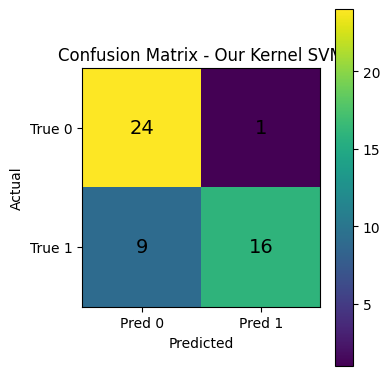

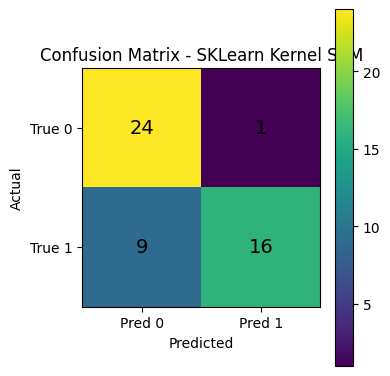

In [180]:
plot_confusion_matrix(cm_ours, "Confusion Matrix - Our Kernel SVM")
plot_confusion_matrix(cm_sk,   "Confusion Matrix - SKLearn Kernel SVM")

In [181]:
def print_metrics(name, y_true, y_pred):
    print(f"=== {name} ===")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print()

print_metrics("Our Kernel SVM", y_test_true, y_test_pred)
print_metrics("SKLearn SVM",   y_test_true, y_test_pred_sk)


print("=== Accuracy Comparison ===")
print(f"Our SVM   - Train: {acc_train_ours:.4f}, Test: {acc_test_ours:.4f}")
print(f"SKLearn   - Train: {acc_train_sk:.4f}, Test: {acc_test_sk:.4f}")

=== Our Kernel SVM ===
Precision: 0.9411764705882353
Recall   : 0.64
F1-score : 0.7619047619047619

=== SKLearn SVM ===
Precision: 0.9411764705882353
Recall   : 0.64
F1-score : 0.7619047619047619

=== Accuracy Comparison ===
Our SVM   - Train: 0.9067, Test: 0.8000
SKLearn   - Train: 0.9067, Test: 0.8000


In [182]:
scores_ours = svm.decision_function(X_test)
scores_sk   = sk_svm.decision_function(X_test)


fpr_ours, tpr_ours, _ = roc_curve(y_test_true, scores_ours)
fpr_sk,   tpr_sk,   _ = roc_curve(y_test_true, scores_sk)

auc_ours = auc(fpr_ours, tpr_ours)
auc_sk   = auc(fpr_sk,   tpr_sk)

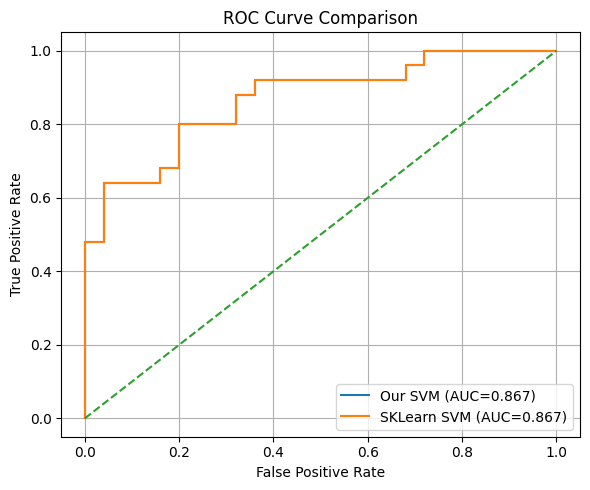

In [183]:
plt.figure(figsize=(6,5))

plt.plot(fpr_ours, tpr_ours, label=f"Our SVM (AUC={auc_ours:.3f})")
plt.plot(fpr_sk,   tpr_sk,   label=f"SKLearn SVM (AUC={auc_sk:.3f})")
plt.plot([0,1], [0,1], '--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [184]:
# فرض کنیم X_train و y_train قبلا لود شده اند
np.random.seed(42)  # برای reproducibility

# shuffle index ها
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# درصد داده برای validation
val_ratio = 0.4
val_size = int(len(indices) * val_ratio)

# تقسیم داده‌ها
val_indices = indices[:val_size]
train_indices = indices[val_size:]

X_val = X_train[val_indices]
y_val = y_train[val_indices]

X_train_cv = X_train[train_indices]
y_train_cv = y_train[train_indices]

In [185]:
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.1, 0.5]

best_score = 0
best_C, best_gamma = None, None

for C in C_values:
    for gamma in gamma_values:
        svm = KernelSVM(C=C, gamma=gamma)
        svm.fit(X_train_cv, y_train_cv)  # فقط داده‌های train CV
        y_pred = svm.predict(X_val)      # داده‌های validation
        score = np.mean(y_pred == y_val) # accuracy
        print(f"C={C}, gamma={gamma}, accuracy={score:.4f}")
        if score > best_score:
            best_score = score
            best_C, best_gamma = C, gamma

print("Best C:", best_C)
print("Best gamma:", best_gamma)
print("Best accuracy on validation:", best_score)

C=0.1, gamma=0.01, accuracy=0.4333
C=0.1, gamma=0.1, accuracy=0.8500
C=0.1, gamma=0.5, accuracy=0.8333
C=1, gamma=0.01, accuracy=0.8500
C=1, gamma=0.1, accuracy=0.8500
C=1, gamma=0.5, accuracy=0.8500
C=10, gamma=0.01, accuracy=0.8500
C=10, gamma=0.1, accuracy=0.8667
C=10, gamma=0.5, accuracy=0.8667
Best C: 10
Best gamma: 0.1
Best accuracy on validation: 0.8666666666666667
